<a href="https://colab.research.google.com/github/Y4-Deep-Learning-Assignment/Pneumonia-_Detection/blob/Xception/Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Xception Transfer Learning for Pneumonia Detection

In [1]:
!nvidia-smi

Sat Oct 11 07:39:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Install and import required libraries

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pip install tensorflow keras numpy pandas matplotlib seaborn scikit-learn -q

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import os
import zipfile
from google.colab import files
import time
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

# Check GPU availability
print("\nGPU Available:", tf.test.is_gpu_available())
if tf.test.is_gpu_available():
    print("GPU Device:", tf.test.gpu_device_name())

TensorFlow version: 2.19.0
Keras version: 3.10.0

GPU Available: True
GPU Device: /device:GPU:0


## Extract Dataset

In [8]:
import zipfile
import shutil

zip_path = "/content/drive/MyDrive/DL Assignment/archive.zip"

shutil.copy(zip_path, "/content/")

# Extract the dataset
print("Extracting dataset...")
with zipfile.ZipFile("/content/archive.zip", 'r') as zip_ref:
    zip_ref.extractall('/content')

print("Dataset structure:")
!find /content/chest_xray -type d -print


Extracting dataset...
Dataset structure:
/content/chest_xray
/content/chest_xray/val
/content/chest_xray/val/PNEUMONIA
/content/chest_xray/val/NORMAL
/content/chest_xray/train
/content/chest_xray/train/PNEUMONIA
/content/chest_xray/train/NORMAL
/content/chest_xray/__MACOSX
/content/chest_xray/__MACOSX/chest_xray
/content/chest_xray/__MACOSX/chest_xray/val
/content/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA
/content/chest_xray/__MACOSX/chest_xray/val/NORMAL
/content/chest_xray/__MACOSX/chest_xray/train
/content/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA
/content/chest_xray/__MACOSX/chest_xray/train/NORMAL
/content/chest_xray/__MACOSX/chest_xray/test
/content/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA
/content/chest_xray/__MACOSX/chest_xray/test/NORMAL
/content/chest_xray/chest_xray
/content/chest_xray/chest_xray/val
/content/chest_xray/chest_xray/val/PNEUMONIA
/content/chest_xray/chest_xray/val/NORMAL
/content/chest_xray/chest_xray/train
/content/chest_xray/chest_xray/train/PNE

## Explore the Dataset

In [9]:
dataset_path = '/content/chest_xray'
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')
val_path = os.path.join(dataset_path, 'val')

def explore_dataset():
    print("Dataset Exploration:")
    print("=" * 50)

    for split in ['train', 'test', 'val']:
        split_path = os.path.join(dataset_path, split)
        normal_path = os.path.join(split_path, 'NORMAL')
        pneumonia_path = os.path.join(split_path, 'PNEUMONIA')

        normal_count = len(os.listdir(normal_path))
        pneumonia_count = len(os.listdir(pneumonia_path))
        total_count = normal_count + pneumonia_count

        print(f"\n{split.upper()} SET:")
        print(f"  Normal images: {normal_count}")
        print(f"  Pneumonia images: {pneumonia_count}")
        print(f"  Total images: {total_count}")
        print(f"  Pneumonia ratio: {pneumonia_count/total_count:.2%}")

explore_dataset()

Dataset Exploration:

TRAIN SET:
  Normal images: 1341
  Pneumonia images: 3875
  Total images: 5216
  Pneumonia ratio: 74.29%

TEST SET:
  Normal images: 234
  Pneumonia images: 390
  Total images: 624
  Pneumonia ratio: 62.50%

VAL SET:
  Normal images: 8
  Pneumonia images: 8
  Total images: 16
  Pneumonia ratio: 50.00%


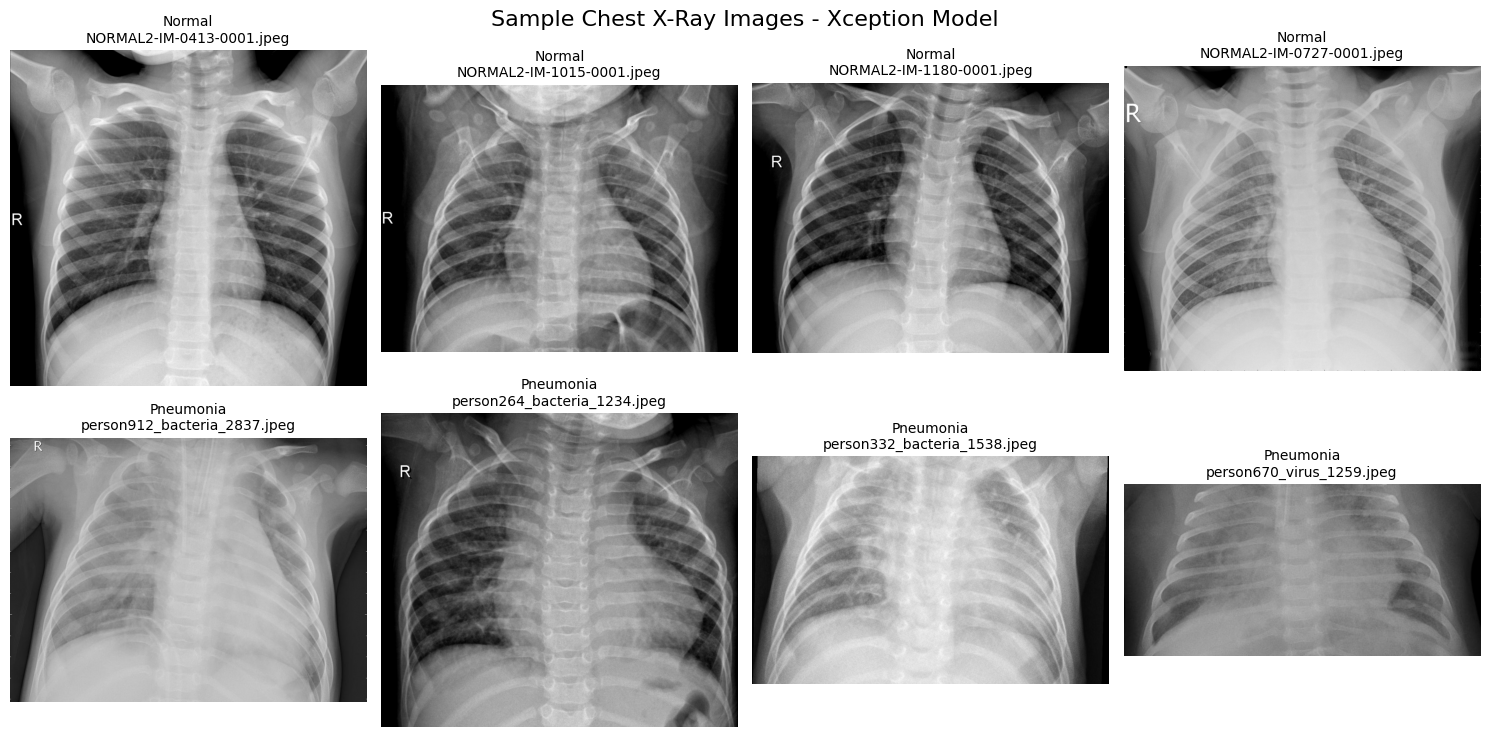

In [10]:
# Visualize sample images
def visualize_samples():
    """Display sample images from both classes"""
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))

    # Normal samples
    normal_path = os.path.join(train_path, 'NORMAL')
    normal_images = [f for f in os.listdir(normal_path) if f.endswith(('.jpeg', '.jpg', '.png'))][:4]

    for i, img_name in enumerate(normal_images):
        img_path = os.path.join(normal_path, img_name)
        img = plt.imread(img_path)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f'Normal\n{img_name}', fontsize=10)
        axes[0, i].axis('off')

    # Pneumonia samples
    pneumonia_path = os.path.join(train_path, 'PNEUMONIA')
    pneumonia_images = [f for f in os.listdir(pneumonia_path) if f.endswith(('.jpeg', '.jpg', '.png'))][:4]

    for i, img_name in enumerate(pneumonia_images):
        img_path = os.path.join(pneumonia_path, img_name)
        img = plt.imread(img_path)
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].set_title(f'Pneumonia\n{img_name}', fontsize=10)
        axes[1, i].axis('off')

    plt.suptitle('Sample Chest X-Ray Images - Xception Model', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

visualize_samples()

## Data Preprocessing and Augmentation

In [12]:
IMG_HEIGHT = 299  # Xception expects 299x299 images
IMG_WIDTH = 299
BATCH_SIZE = 32

print("Setting up data generators for Xception...")

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2,
    brightness_range=[0.9, 1.1],
    fill_mode='constant',
    cval=0
)

# Only rescaling for validation and test
val_test_datagen = ImageDataGenerator(rescale=1./255)

Setting up data generators for Xception...


In [13]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    seed=42
)

validation_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

# Display class information
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

print(f"\nData generators created successfully!")
print(f"Class indices: {class_indices}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Class names: {class_names}")

# Calculate class weights for handling imbalance
normal_count = len(os.listdir(os.path.join(train_path, 'NORMAL')))
pneumonia_count = len(os.listdir(os.path.join(train_path, 'PNEUMONIA')))
total = normal_count + pneumonia_count

weight_for_0 = total / (2 * normal_count)    # Weight for NORMAL
weight_for_1 = total / (2 * pneumonia_count)  # Weight for PNEUMONIA

class_weights = {0: weight_for_0, 1: weight_for_1}
print(f"Class weights: {class_weights}")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

Data generators created successfully!
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Training samples: 5216
Validation samples: 16
Test samples: 624
Class names: ['NORMAL', 'PNEUMONIA']
Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


## Build Xception Transfer Learning Model

In [15]:
def create_xception_model():
    """
    Create Xception transfer learning model for pneumonia detection
    Xception is known for its depthwise separable convolutions
    """
    print("Building Xception model...")

    # Load pre-trained Xception
    base_model = Xception(
        weights='imagenet',       # Pre-trained on ImageNet
        include_top=False,        # Exclude the final classification layers
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )

    # Freeze the base model layers initially
    base_model.trainable = False

    # Create the complete model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )

    return model

# Create the model
xception_model = create_xception_model()

# Display model summary
print("\nXception Model Summary:")
xception_model.summary()

Building Xception model...

Xception Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,086,185 (84.25 MB)

 Trainable params: 1,219,073 (4.65 MB)

 Non-trainable params: 20,867,112 (79.60 MB)

## Define Callbacks for Training

In [17]:
def setup_callbacks():
    """
    Set up callbacks for efficient training
    """
    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    )

    # Reduce learning rate when validation loss plateaus
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    # Save the best model
    checkpoint = ModelCheckpoint(
        'best_xception_pneumonia_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    return [early_stop, reduce_lr, checkpoint]

callbacks = setup_callbacks()
print("Callbacks setup complete!")

Callbacks setup complete!


## Train the Model

In [18]:
print("Starting Xception model training...")
EPOCHS = 30

# Calculate steps per epoch
train_steps = train_generator.samples // BATCH_SIZE
val_steps = validation_generator.samples // BATCH_SIZE

print(f"Training steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {val_steps}")
print(f"Maximum epochs: {EPOCHS}")

# Start timer
start_time = time.time()

# Train the model
history = xception_model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=val_steps,
    callbacks=callbacks,
    class_weight=class_weights,  # Important for handling imbalance
    verbose=1
)

training_time = time.time() - start_time
print(f"\nXception training completed in {training_time/60:.2f} minutes!")

Starting Xception model training...
Training steps per epoch: 163
Validation steps per epoch: 0
Maximum epochs: 30
Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7121 - auc: 0.7978 - loss: 0.5260 - precision: 0.8952 - recall: 0.6986
Epoch 1: val_accuracy improved from -inf to 0.81250, saving model to best_xception_pneumonia_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.7125 - auc: 0.7984 - loss: 0.5254 - precision: 0.8955 - recall: 0.6990 - val_accuracy: 0.8125 - val_auc: 1.0000 - val_loss: 0.4032 - val_precision: 1.0000 - val_recall: 0.6250 - learning_rate: 1.0000e-04
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8746 - auc: 0.9531 - loss: 0.2866 - precision: 0.9744 - recall: 0.8536
Epoch 2: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.8747 - auc: 0.9531 - loss: 0.2864 - precision: 0.9744 - recall: 0.8536 - val_accuracy: 0.8125 - val_auc: 1.0000 - val_loss: 0.2930 - val_precision: 1.0000 - val_recall: 0.6250 - learning_rate: 1.0000e-04
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9108 - auc: 0.9713 - loss: 0.2188 - precision: 0.9763 - recall: 0.9010
Epoch 3: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9108 - auc: 0.9713 - loss: 0.2188 - precision: 0.9

## Evaluate the Model

In [22]:
def evaluate_xception_model_safe(model, test_generator):
    """
    Ultra-safe evaluation that handles any metric naming issues
    """
    print("\nEvaluating Xception model on test set...")

    # Get the actual metric names
    print("Available metrics:", model.metrics_names)

    # Evaluate and get results as dictionary (TensorFlow 2.4+)
    try:
        test_results = model.evaluate(test_generator, verbose=1, return_dict=True)
        print("Results as dictionary:", test_results)
    except:
        # Fallback for older TensorFlow versions
        test_results = model.evaluate(test_generator, verbose=1)
        metrics_dict = dict(zip(model.metrics_names, test_results))
        print("Results as list:", test_results)
        print("Metrics dictionary:", metrics_dict)
        test_results = metrics_dict

    print(f"\nXception Test Results:")

    # Extract all available metrics
    for metric_name, value in test_results.items():
        print(f"{metric_name}: {value:.4f}")

    # Calculate F1-score from available metrics
    precision = test_results.get('precision', 0.0)
    recall = test_results.get('recall', 0.0)

    if precision + recall > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
        print(f"F1-Score: {f1_score:.4f}")

    # Make predictions
    print("\nMaking predictions...")
    test_generator.reset()
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # True labels
    true_classes = test_generator.classes

    # Classification report
    print("\nClassification Report:")
    print(classification_report(true_classes, predicted_classes,
                              target_names=['NORMAL', 'PNEUMONIA'], digits=4))

    return test_results, predictions, predicted_classes

# Use the safe evaluation function
test_metrics, predictions, predicted_classes = evaluate_xception_model_safe(xception_model, test_generator)


Evaluating Xception model on test set...
Available metrics: ['loss', 'compile_metrics']
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - accuracy: 0.8546 - auc: 0.6210 - loss: 0.4419 - precision: 0.5367 - recall: 0.5551
Results as dictionary: {'accuracy': 0.8285256624221802, 'auc': 0.9261889457702637, 'loss': 0.4532078504562378, 'precision': 0.9125364422798157, 'recall': 0.8025640845298767}

Xception Test Results:
accuracy: 0.8285
auc: 0.9262
loss: 0.4532
precision: 0.9125
recall: 0.8026
F1-Score: 0.8540

Making predictions...
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 344ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.7260    0.8718    0.7922       234
   PNEUMONIA     0.9125    0.8026    0.8540       390

    accuracy                         0.8285       624
   macro avg     0.8193    0.8372    0.8231       624
weighted avg     0.8426    0.8285    0.8309       624



## Visualize Results

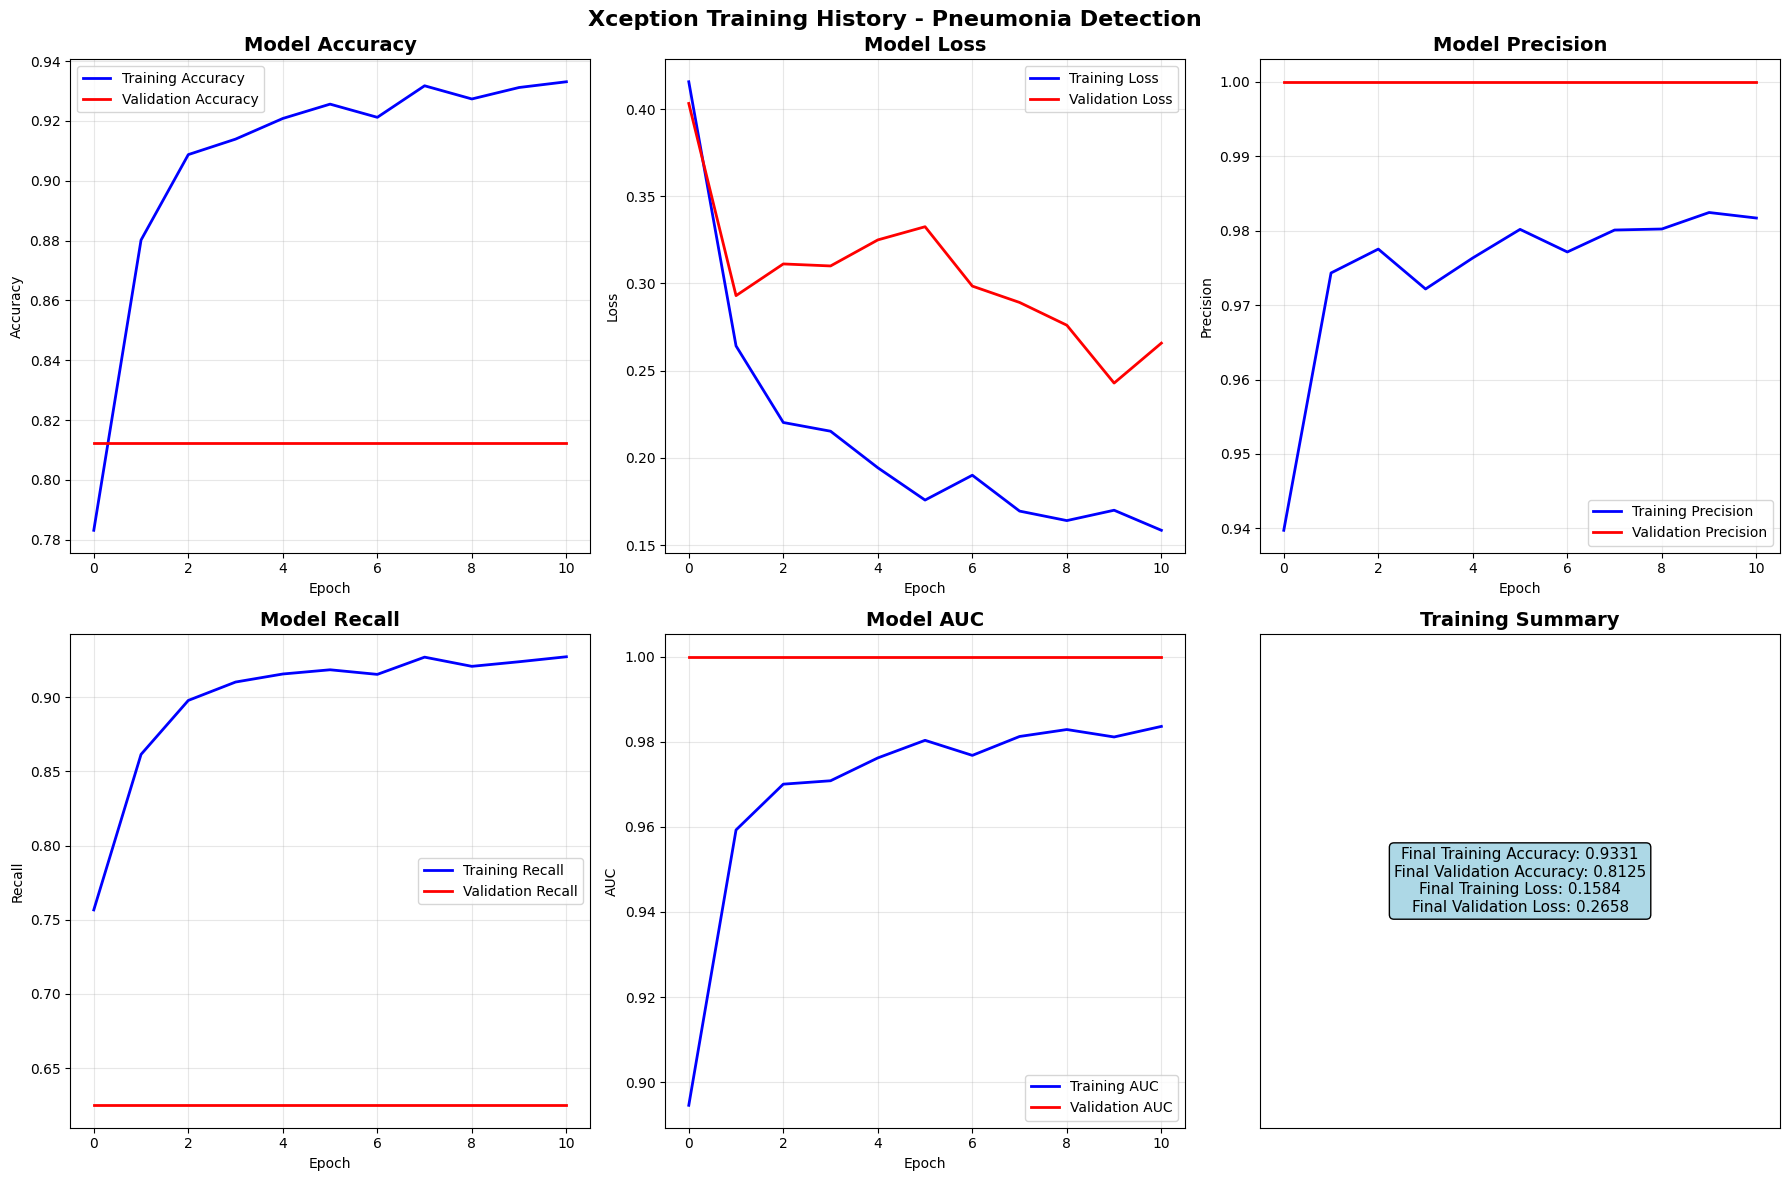

In [24]:
def plot_training_history_simple(history):
    """
    Plot comprehensive training history without fine-tuning
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='blue')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='red')
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Precision
    if 'precision' in history.history:
        axes[0, 2].plot(history.history['precision'], label='Training Precision', linewidth=2, color='blue')
        axes[0, 2].plot(history.history['val_precision'], label='Validation Precision', linewidth=2, color='red')
        axes[0, 2].set_title('Model Precision', fontsize=14, fontweight='bold')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('Precision')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
    else:
        axes[0, 2].text(0.5, 0.5, 'Precision data\nnot available',
                       horizontalalignment='center', verticalalignment='center',
                       transform=axes[0, 2].transAxes, fontsize=12)
        axes[0, 2].set_title('Model Precision', fontsize=14, fontweight='bold')

    # Recall
    if 'recall' in history.history:
        axes[1, 0].plot(history.history['recall'], label='Training Recall', linewidth=2, color='blue')
        axes[1, 0].plot(history.history['val_recall'], label='Validation Recall', linewidth=2, color='red')
        axes[1, 0].set_title('Model Recall', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Recall')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'Recall data\nnot available',
                       horizontalalignment='center', verticalalignment='center',
                       transform=axes[1, 0].transAxes, fontsize=12)
        axes[1, 0].set_title('Model Recall', fontsize=14, fontweight='bold')

    # AUC
    if 'auc' in history.history:
        axes[1, 1].plot(history.history['auc'], label='Training AUC', linewidth=2, color='blue')
        axes[1, 1].plot(history.history['val_auc'], label='Validation AUC', linewidth=2, color='red')
        axes[1, 1].set_title('Model AUC', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('AUC')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'AUC data\nnot available',
                       horizontalalignment='center', verticalalignment='center',
                       transform=axes[1, 1].transAxes, fontsize=12)
        axes[1, 1].set_title('Model AUC', fontsize=14, fontweight='bold')

    # Learning Rate
    if 'lr' in history.history:
        axes[1, 2].plot(history.history['lr'], label='Learning Rate', linewidth=2, color='purple')
        axes[1, 2].set_title('Learning Rate', fontsize=14, fontweight='bold')
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('Learning Rate')
        axes[1, 2].set_yscale('log')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
    else:
        # Show training summary instead
        final_train_acc = history.history['accuracy'][-1]
        final_val_acc = history.history['val_accuracy'][-1]
        final_train_loss = history.history['loss'][-1]
        final_val_loss = history.history['val_loss'][-1]

        summary_text = f"Final Training Accuracy: {final_train_acc:.4f}\nFinal Validation Accuracy: {final_val_acc:.4f}\nFinal Training Loss: {final_train_loss:.4f}\nFinal Validation Loss: {final_val_loss:.4f}"

        axes[1, 2].text(0.5, 0.5, summary_text,
                       horizontalalignment='center', verticalalignment='center',
                       transform=axes[1, 2].transAxes, fontsize=11,
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
        axes[1, 2].set_title('Training Summary', fontsize=14, fontweight='bold')
        axes[1, 2].set_xticks([])
        axes[1, 2].set_yticks([])

    plt.suptitle('Xception Training History - Pneumonia Detection', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history_simple(history)

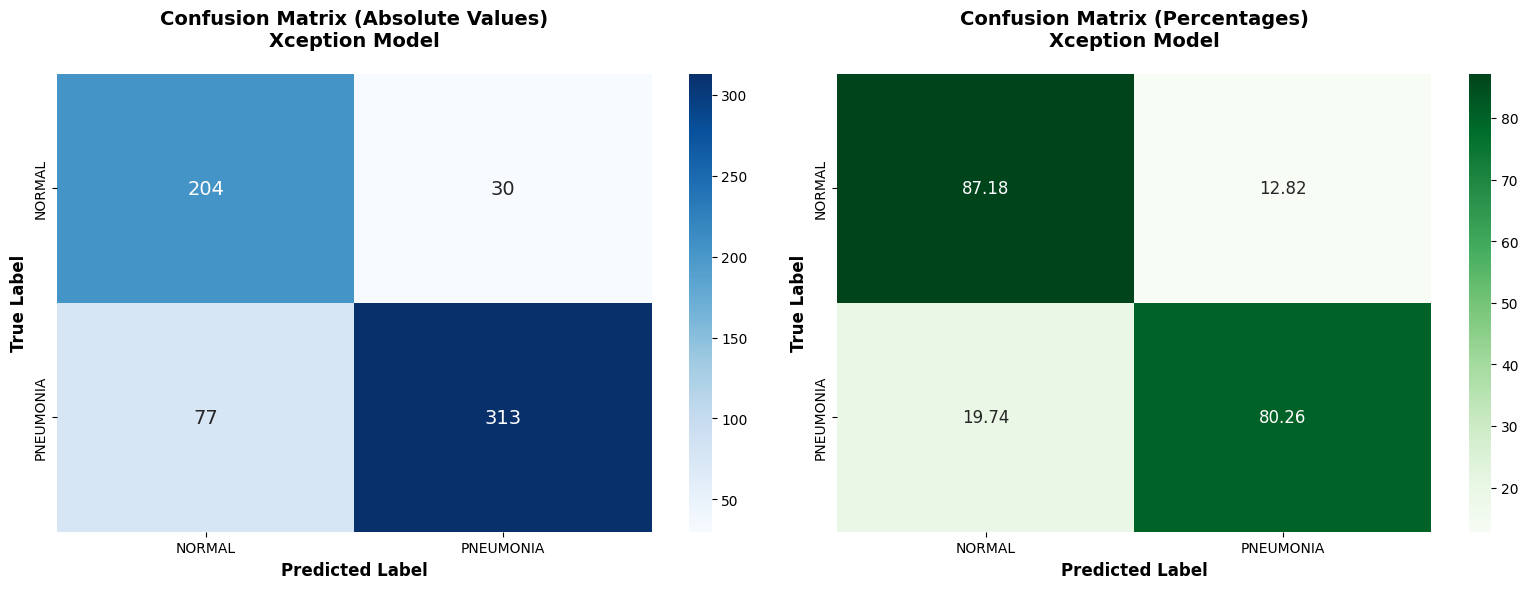

Confusion Matrix Analysis:
True Negatives (Normal correctly classified): 204 (87.2%)
False Positives (Normal misclassified as Pneumonia): 30 (12.8%)
False Negatives (Pneumonia misclassified as Normal): 77 (19.7%)
True Positives (Pneumonia correctly classified): 313 (80.3%)


In [26]:
# Plot confusion matrix
def plot_confusion_matrix_detailed(test_generator, predicted_classes):
    """
    Plot detailed confusion matrix with percentages
    """
    cm = confusion_matrix(test_generator.classes, predicted_classes)

    # Calculate percentages
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot absolute values
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['NORMAL', 'PNEUMONIA'],
                yticklabels=['NORMAL', 'PNEUMONIA'],
                annot_kws={"size": 14})
    ax1.set_title('Confusion Matrix (Absolute Values)\nXception Model',
                  fontsize=14, fontweight='bold', pad=20)
    ax1.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax1.set_ylabel('True Label', fontsize=12, fontweight='bold')

    # Plot percentages
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Greens', ax=ax2,
                xticklabels=['NORMAL', 'PNEUMONIA'],
                yticklabels=['NORMAL', 'PNEUMONIA'],
                annot_kws={"size": 12})
    ax2.set_title('Confusion Matrix (Percentages)\nXception Model',
                  fontsize=14, fontweight='bold', pad=20)
    ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print numerical analysis
    print("Confusion Matrix Analysis:")
    print(f"True Negatives (Normal correctly classified): {cm[0,0]} ({cm_percentage[0,0]:.1f}%)")
    print(f"False Positives (Normal misclassified as Pneumonia): {cm[0,1]} ({cm_percentage[0,1]:.1f}%)")
    print(f"False Negatives (Pneumonia misclassified as Normal): {cm[1,0]} ({cm_percentage[1,0]:.1f}%)")
    print(f"True Positives (Pneumonia correctly classified): {cm[1,1]} ({cm_percentage[1,1]:.1f}%)")

plot_confusion_matrix_detailed(test_generator, predicted_classes)

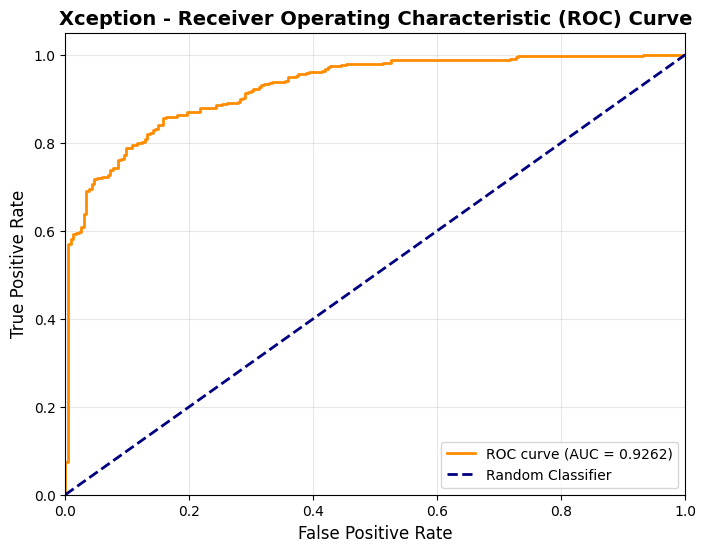

ROC AUC Score: 0.9262


In [27]:
# Plot ROC Curve
def plot_roc_curve(test_generator, predictions):
    """
    Plot ROC curve for model performance
    """
    fpr, tpr, thresholds = roc_curve(test_generator.classes, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Xception - Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

    return roc_auc

roc_auc = plot_roc_curve(test_generator, predictions)
print(f"ROC AUC Score: {roc_auc:.4f}")

## Sample Predictions Visualization

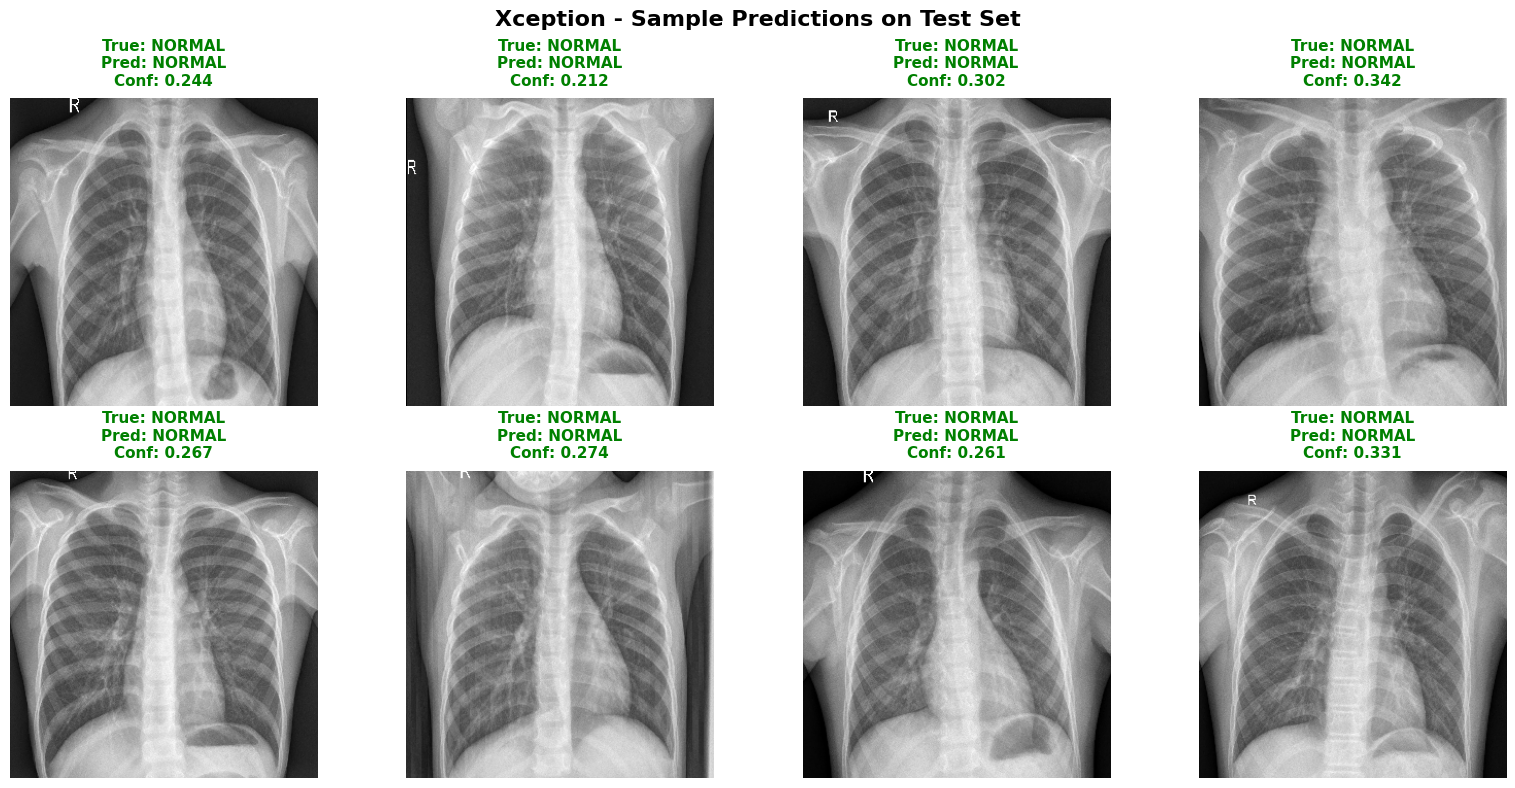

In [28]:
def display_sample_predictions(model, test_generator, num_samples=8):
    """
    Display sample predictions with true and predicted labels
    """
    # Get a batch of test data
    test_generator.reset()
    x_batch, y_batch = next(test_generator)

    # Make predictions for this batch
    predictions = model.predict(x_batch[:num_samples], verbose=0)
    predicted_labels = (predictions > 0.5).astype(int).flatten()
    true_labels = y_batch[:num_samples].astype(int)

    # Class names
    class_names_dict = {0: 'NORMAL', 1: 'PNEUMONIA'}

    # Plot samples
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    for i in range(num_samples):
        axes[i].imshow(x_batch[i])
        axes[i].axis('off')

        true_class = class_names_dict[true_labels[i]]
        pred_class = class_names_dict[predicted_labels[i]]
        confidence = predictions[i][0]

        # Color code: green for correct, red for incorrect
        color = 'green' if true_labels[i] == predicted_labels[i] else 'red'

        title = f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.3f}'
        axes[i].set_title(title, color=color, fontsize=11, fontweight='bold', pad=10)

    plt.suptitle('Xception - Sample Predictions on Test Set',
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

display_sample_predictions(xception_model, test_generator)